In [1]:


import json
import os
import sys
import tomllib
import re
import pandas as pd
import evaluate
import sys
import os
import json
from argparse import ArgumentParser
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from spacy.lang.it.examples import sentences
import matplotlib.pyplot as plt
import pandas as pd
import scipy

result_path = "/Users/micheleyin/Documents/Elicitation/LLMs-runner/results/narrative_elicitation/"
human_path = "/Users/micheleyin/Documents/Elicitation/crowdsourcing_narrative_elicitation/output_dataset/test_set.json"


In [2]:
# list all files in directory recursively
def list_files(path):
    r = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if name.endswith(".json"):
                r.append(os.path.join(root, name))
    return r
input_files = list_files(result_path)
input_files.sort()
# input_files

In [3]:
def retrieve_data(input_files, with_prompt=False):
    models_data = {}
    for file in input_files:
        with open(file,'rb') as f:
            data = json.load(f)
        model_name = data[0]["model_name"]
        models_data[model_name] = model_name
        narratives = data[0]["results"]
        inputs = []
        answers = []
        for narrative in narratives:
            try:
                input_text = " ".join(narrative["input"].split()) + " "
                text = " ".join(narrative["output"][0]["generated_text"].split()).strip()
                text = re.split(r'([?])', text)
                try: 
                    text = text[0] + text[1]
                except IndexError:
                    text = text[0]
            except TypeError:
                print(f"input text is not a string: {narrative}")
            if with_prompt:
                answer = text[text.find(input_text)+len(input_text)+len(' DOMANDA:'):].strip()
                # split by period, question mark, exclamation mark and keep the punctuation
                answer = re.split(r'([.!?])', answer)
                try:
                    answer = answer[0] + answer[1]
                except IndexError:
                    answer = answer[0]
            else:
                answer = text
            inputs.append(input_text)
            answers.append(answer)
        models_data[model_name] = {"inputs": inputs, "answers": answers}
    return models_data

In [4]:
def retrieve_human_data(input_files):
    models_data = {}
    for file in input_files:
        with open(file,'rb') as f:
            data = json.load(f)
        model_name = data[0]["model_name"]
        models_data[model_name] = model_name
        narratives = data[0]["results"]
        inputs = []
        answers = []
        for narrative in narratives:
            input_text = " ".join(narrative["input"].split()) + " "
            answer = [i["generated_text"] for i in narrative["output"]]
            inputs.append(input_text)
            answers.append(answer)
        models_data[model_name] = {"inputs": inputs, "answers": answers}
    return models_data

In [5]:
# models_data
human_data = retrieve_human_data([human_path])

In [6]:
def token_distribution_compute(input_files):
    nlp = spacy.load("it_core_news_lg")
    # token prompt distribution
    token_distribution = {}
    for input_file in input_files:
        with open(input_file, "r") as f:
            data = json.load(f)
        for item in data[0]["results"]:
            text = " ".join(item["input"].split()) + " "
            doc = nlp(text)
            for token in doc:
                if (
                    not token.is_punct
                    and not token.is_space
                    and not token.is_stop
                    and not token.is_digit
                    and not token.is_oov
                    and not token.is_currency
                ):
                    if token.text.lower() not in token_distribution:
                        token_distribution[token.text.lower()] = 0
                    token_distribution[token.text.lower()] += 1
    # sort by frequency
    token_distribution_list = sorted(
        token_distribution.items(), key=lambda x: x[1], reverse=True
    )
    return token_distribution,token_distribution_list
token_distribution_prompt,token_distribution_list = token_distribution_compute([input_files[0]])
print(f"There are {len(token_distribution_list)} unique tokens in the prompt dataset")

There are 628 unique tokens in the prompt dataset


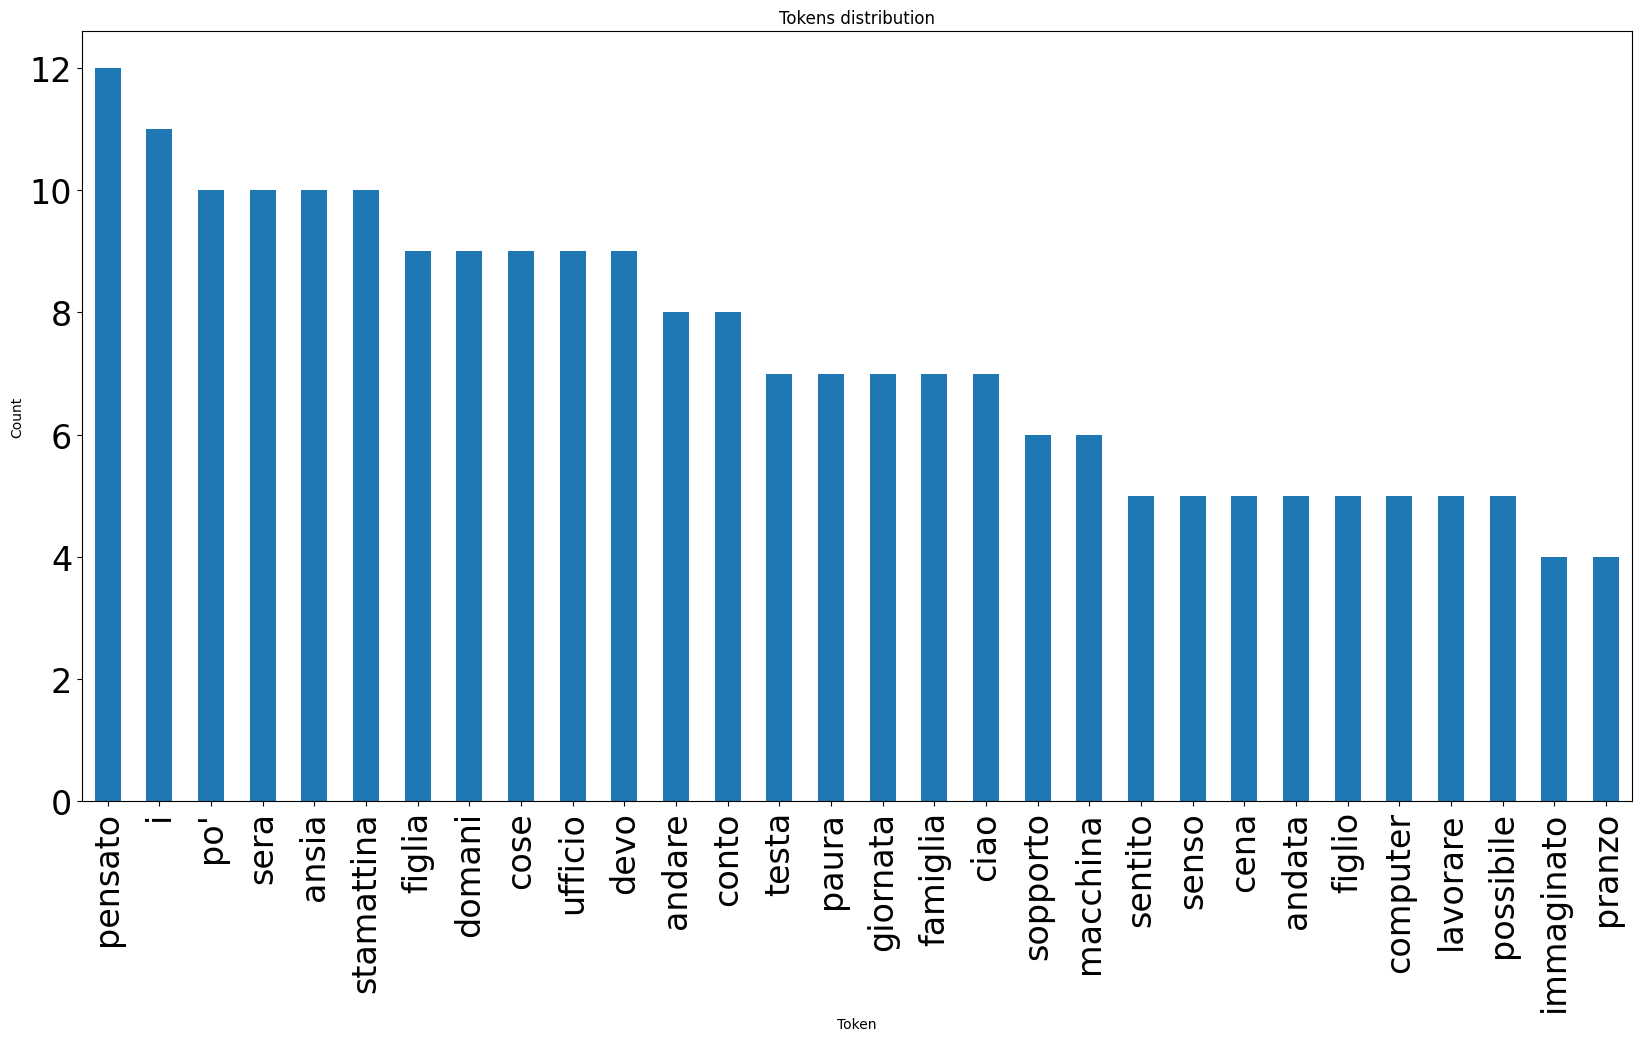

In [7]:
# plt.rcParams.update({'font.size': 28}) # must set in top
df = pd.DataFrame.from_dict( token_distribution_prompt, orient='index' ).sort_values(0, ascending=False).head(30).plot(kind='bar', figsize=(20,10), fontsize=24, xlabel='Token', ylabel='Count', title='Tokens distribution', legend=False)
# plt.bar(df.index, df[0])

In [8]:

def token_distribution_compute(input_files):
    nlp = spacy.load("it_core_news_lg")
    # token prompt distribution
    token_distribution = {}
    for input_file in input_files:
        with open(input_file, "r") as f:
            data = json.load(f)
        for item in data[0]["results"]:
            text = " ".join(item["output"][0]["generated_text"].split()).strip()
            text = re.split(r'([?])', text)[0]
            doc = nlp(text)
            for token in doc:
                if (
                    not token.is_punct
                    and not token.is_space
                    and not token.is_stop
                    and not token.is_digit
                    and not token.is_oov
                    and not token.is_currency
                ):
                    if token.text.lower() not in token_distribution:
                        token_distribution[token.text.lower()] = 0
                    token_distribution[token.text.lower()] += 1
    # sort by frequency
    token_distribution_list = sorted(
        token_distribution.items(), key=lambda x: x[1], reverse=True
    )
    return token_distribution,token_distribution_list
def token_distribution_whole(input_files):
    token_distribution = {}
    for file in input_files:
        a,_ = token_distribution_compute([file])
        'no_color/no_guidelines/0_shot/falcon-7b.json'
        model_name = file.split('/')[-1].split('.')[0]
        color = file.split('/')[-4]
        guideline = file.split('/')[-3]
        shot = file.split('/')[-2]
        try:
            token_distribution[color][guideline][shot][model_name] = a
        except KeyError:
            try:
                token_distribution[color][guideline][shot] = {model_name: a}
            except KeyError:
                try:
                    token_distribution[color][guideline] = {shot: {model_name: a}}
                except KeyError:
                    try:
                        token_distribution[color] = {guideline: {shot: {model_name: a}}}
                    except KeyError:
                        token_distribution = {color: {guideline: {shot: {model_name: a}}}}
    return token_distribution
token_distribution = token_distribution_whole(input_files)


In [9]:

def token_distribution_compute(input_files):
    nlp = spacy.load("it_core_news_lg")
    # token prompt distribution
    token_distribution = {}
    for input_file in input_files:
        with open(input_file, "r") as f:
            data = json.load(f)
        for item in data[0]["results"]:
            text = " ".join(item["output"][0]["generated_text"].split()).strip()
            text = re.split(r'([?])', text)[0]
            doc = nlp(text)
            for token in doc:
                if (
                    not token.is_punct
                    and not token.is_space
                    and not token.is_stop
                    and not token.is_digit
                    and not token.is_oov
                    and not token.is_currency
                ):
                    if token.text.lower() not in token_distribution:
                        token_distribution[token.text.lower()] = 0
                    token_distribution[token.text.lower()] += 1
    # sort by frequency
    token_distribution_list = sorted(
        token_distribution.items(), key=lambda x: x[1], reverse=True
    )
    return token_distribution,token_distribution_list
token_distribution_human,_ = token_distribution_compute([human_path])

In [10]:
token_distribution

{'no_color': {'no_guidelines': {'0_shot': {'Wizard-Vicuna-13B-Uncensored-HF': {'trascorso': 1,
     'giornata': 3,
     'attivo': 1,
     'ultimi': 1,
     'deciso': 2,
     'andare': 1,
     'figlia': 4,
     'i': 3,
     'dettagli': 1,
     'importanti': 1,
     'fornito': 1,
     'narrazione': 2,
     'lavorativa': 1,
     'dispiace': 1,
     'chiederti': 1,
     'preoccupata': 1,
     'papà': 2,
     'andata': 2,
     'stasera': 1,
     'serata': 1,
     'piovuto': 1,
     'neve': 1,
     'genere': 2,
     'malanni': 1,
     'possono': 3,
     'causati': 1,
     'peggiore': 1,
     'accadde': 1,
     'sentire': 2,
     'madre': 1,
     'evening': 1,
     'regali': 1,
     'dato': 2,
     'collega': 2,
     'cari': 1,
     'pranzo': 1,
     'natale': 1,
     'imparato': 1,
     'inglese': 1,
     "cos'": 1,
     'posizione': 1,
     'azienda': 1,
     'successe': 1,
     'macchina': 1,
     'persona': 8,
     'narrando': 1,
     'stress': 1,
     'protagonista': 4,
     'narrativa':

In [11]:
import matplotlib as mpl

colors = [mpl.colors.hsv_to_rgb([(i)/9, 1, 0.90]) for i in range(9)]
print (colors)

[array([0.9, 0. , 0. ]), array([0.9, 0.6, 0. ]), array([0.6, 0.9, 0. ]), array([0. , 0.9, 0. ]), array([0. , 0.9, 0.6]), array([0. , 0.6, 0.9]), array([0. , 0. , 0.9]), array([0.6, 0. , 0.9]), array([0.9, 0. , 0.6])]


In [12]:
colors
sorted_colors = [colors[-1],
                 colors[1],
                 colors[0],
                 colors[2],
                 colors[3],
                 colors[5],
                 colors[4],
                 colors[6],
                 colors[7]]

In [13]:
token_distribution['no_color']['no_guidelines']['0_shot'].keys()

dict_keys(['Wizard-Vicuna-13B-Uncensored-HF', 'falcon-40b-instruct', 'falcon-7b', 'gpt-3', 'gpt-4', 'mpt-30b-chat', 'mpt-7b', 'vicuna-13b-v1', 'vicuna-33b-v1'])

In [14]:
img_path = '/Users/micheleyin/Documents/Elicitation/LLMs-runner/data_analysis/json_format/img_vertical'
# plt.rcParams.update({'font.size': 28}) # must set in top
for c,color in token_distribution.items():
    for g,guidelines in color.items():
        for s,shot in guidelines.items():
            # sort the models by name
            
            for color,(m,model) in zip(sorted_colors,shot.items()):
                sort = sorted(model.items(), key=lambda x: x[1], reverse=True)
                print(sort[0])
                max = sort[0][1]
                # print (model)
                fig_size = (3*max/40,18)
                df = pd.DataFrame.from_dict( model, orient='index' )

                df.rename_axis('Token', inplace=True)
                df.sort_values([0,'Token'], ascending=False).head(50).plot(color= color,kind='barh', figsize=fig_size,
                                                                                                                   fontsize=20,
                                                                                                                #    xlabel='Counts', 
                                                                                                                ylabel='',
                                                                                                                # title='Tokens distribution in the Elicitations',
                                                                                                                   legend=False)
                model_name = m.replace('Wizard-Vicuna-13B-Uncensored-HF','Wizard Vicuna 13B\nUncensored HF')
                model_name = model_name.replace('falcon-7b', 'Falcon 7B\n')
                model_name = model_name.replace('falcon-40b-instruct','Falcon 40B Instruct\n')
                model_name = model_name.replace('gpt-3', 'Gpt 3\n')
                model_name = model_name.replace('gpt-4', 'Gpt 4\n')
                model_name = model_name.replace('mpt-7b', 'Mpt 7B\n')
                model_name = model_name.replace('mpt-30b-chat', 'Mpt 30B Chat\n')
                model_name = model_name.replace('vicuna-13b-v1', 'Vicuna 13B V1\n')
                model_name = model_name.replace('vicuna-33b-v1', 'Vicuna 33B V1\n')
                title = f"{'With Colour' if c == 'with_color' else 'Without Colour'} {'With Guidelines' if g == 'with_guidelines' else 'Without Guidelines'} {' '.join(s.split('_'))} {model_name}"
                # print (title)
                title = title.replace('Colour ' , 'Colour\n')
                title = title.replace('Guidelines ' , 'Guidelines\n')
                title = title.replace('shot ' , 'shot\n')
                # plt.title(title, fontsize=24, loc='left')
                    # weight="bold",
                # plt.ylim(0, 65)
                # plt.xlim(0, max*1.1)
                plt.gca().invert_yaxis()
                ax = plt.gca()
                ax.text(x=-25, y=-1, s=title, 
                    fontsize=22) #
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                # ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)
                path = f"{img_path}/{c}/{g}/{s}/token_distribution_{c}_{g}_{s}_{m}.png"
                os.makedirs(f"{img_path}/{c}/{g}/{s}/", exist_ok=True)
                # plt.show()
                # break  
                plt.savefig(path, bbox_inches='tight', transparent=True)
                # plt.savefig(path)
                plt.close()
                # break
    #         break
    #     break
    # break
            # break
# plt.bar(df.index, df[0])

('persona', 8)
('racconto', 8)
('domanda', 64)
('qual', 17)
('spiegare', 12)
('`', 35)
('domanda', 19)
('i', 12)
('qual', 12)
('successo', 4)
('dispiace', 10)
('domanda', 20)
('riguardo', 9)
('potresti', 19)
('`', 15)
('felice', 9)
('situazione', 9)
('padre', 7)
('sentire', 8)
('dispiace', 16)
('i', 14)
('chiedo', 24)
('sentire', 29)
('`', 21)
('felice', 5)
('giornata', 10)
('tipo', 7)
('provato', 4)
('the', 10)
('domanda', 10)
('sentire', 39)
('dispiace', 22)
('`', 15)
('dispiace', 18)
('capisco', 9)
('tipo', 6)
('o', 7)
('the', 120)
('chiedo', 11)
('capisco', 17)
('capisco', 48)
('=', 21)
('felice', 12)
('`', 18)
('`', 18)
('narrativa', 5)
('the', 23)
('oh', 33)
('sentire', 24)
('capisco', 51)
('capisco', 15)
('felice', 30)
('situazione', 10)
('`', 24)
('oh', 10)
('the', 21)
('oh', 23)
('sentire', 34)
('puoi', 37)
('capisco', 21)
('the', 13)
('capisco', 17)
('dispiace', 13)
('capisco', 10)
('domanda', 26)
('dispiace', 36)
('capisco', 31)
('capisco', 24)
('capisco', 19)
('capisco', 10

In [15]:
def token_overlap_compute(token_distribution,token_distribution_answers):
    token_overlap = {}
    for token, count in token_distribution.items():
        if token in token_distribution_answers:
            if token in token_overlap:
                token_overlap[token] += count
            else:
                token_overlap[token] = count
    return token_overlap
def token_overlap_whole(token_distribution,token_distribution_answers):
    token_overlap = {}
    for c,color in token_distribution.items():
        for g,guidelines in color.items():
            for s,shot in guidelines.items():
                for m,model in shot.items():
                    try:
                        token_overlap[c][g][s][m] = token_overlap_compute(token_distribution[c][g][s][m],token_distribution_answers)
                    except KeyError:
                        try:
                            token_overlap[c][g][s] = {m: token_overlap_compute(token_distribution[c][g][s][m],token_distribution_answers)}
                        except KeyError:
                            try:
                                token_overlap[c][g] = {s: {m: token_overlap_compute(token_distribution[c][g][s][m],token_distribution_answers)}}
                            except KeyError:
                                try:
                                    token_overlap[c] = {g: {s: {m: token_overlap_compute(token_distribution[c][g][s][m],token_distribution_answers)}}}
                                except KeyError:
                                    token_overlap = {c: {g: {s: {m: token_overlap_compute(token_distribution[c][g][s][m],token_distribution_answers)}}}}
    return token_overlap
token_overlap = token_overlap_whole(token_distribution,token_distribution_prompt)

In [16]:
from copy import deepcopy
token_overlap_copy = deepcopy(token_overlap)
for c,color in token_overlap.items():
    for g,guidelines in color.items():
        for s,shot in guidelines.items():
            for m,model in shot.items():
                if m == 'mpt-7b':
                    del(token_overlap_copy[c][g][s][m])


                if m == 'mpt-30b-chat':

                    del(token_overlap_copy[c][g][s][m])
token_overlap_lens = {}
for c,color in token_overlap_copy.items():
    for g,guidelines in color.items():
        for s,shot in guidelines.items():
            for m,model in shot.items():
                try:
                    token_overlap_lens[c][g][s][m] = len(token_overlap_copy[c][g][s][m])
                except KeyError:
                    try:
                        token_overlap_lens[c][g][s] = {m: len(token_overlap_copy[c][g][s][m])}
                    except KeyError:
                        try:
                            token_overlap_lens[c][g] = {s: {m: len(token_overlap_copy[c][g][s][m])}}
                        except KeyError:
                            try:
                                token_overlap_lens[c] = {g: {s: {m: len(token_overlap_copy[c][g][s][m])}}}
                            except KeyError:
                                token_overlap_lens = {c: {g: {s: {m: len(token_overlap_copy[c][g][s][m])}}}}


In [17]:
df = pd.DataFrame.from_dict({(i,j,k): token_distribution[i][j][k] 
                           for i in token_distribution.keys() 
                           for j in token_distribution[i].keys()
                           for k in token_distribution[i][j].keys()},
                       orient='index')
df

Wizard-Vicuna-13B-Uncensored-HF  \
no_color   no_guidelines   0_shot  {'trascorso': 1, 'giornata': 3, 'attivo': 1, '...   
                           1_shot  {'felice': 1, 'godendo': 1, 'libero': 1, 'gest...   
                           3_shot  {'andata': 1, 'trovare': 2, 'po'': 1, 'tipo': ...   
                           5_shot  {'rilassando': 1, 'lavorando': 1, 'senti': 3, ...   
           with_guidelines 0_shot  {'gioco': 1, 'preferito': 1, 'felice': 1, 'o':...   
                           1_shot  {'ciao': 1, 'rilassata': 1, 'preoccupi': 1, 'p...   
                           3_shot  {'chiedo': 6, 'particolare': 4, 'settimana': 1...   
                           5_shot  {'forte': 1, 'sensazione': 3, 'passato': 1, 'b...   
with_color no_guidelines   0_shot  {'interessanti': 1, 'giornata': 1, 'relax': 1,...   
                           1_shot  {'posso': 4, 'chiederti': 1, 'leggere': 1, 'me...   
                           3_shot  {'passato': 2, 'bella': 1, 'giornata': 6, 'pia...   
                           5_shot  {'piacerebbe': 2, 'sapere': 2, 'trascorso': 2,...   
           with_guidelines 0_shot  {'sì': 2, 'capisco': 2, 'sapresti': 1, 'dirmi'...   
                           1_shot  {'riesci': 1, 'trovare': 1, 'stare': 1, 'famig...   
                           3_shot  {'senti': 2, 'felice': 5, 'sentire': 6, 'occup...   
                           5_shot  {'felice': 3, 'sentirti': 1, 'rilassata': 1, '...   

                                                                 falcon-40b-instruct  \
no_color   no_guidelines   0_shot  {'perchè': 1, 'importante': 2, 'rilassarsi': 1...   
                           1_shot  {'sì': 1, 'bel': 1, 'trovi': 1, 'reso': 1, 'fe...   
                           3_shot  {'contento': 7, 'piaciuto': 1, 'film': 2, 'gio...   
                           5_shot  {'ottimo': 2, 'sentire': 6, 'rilassato': 1, 'c...   
           with_guidelines 0_shot  {'tabella': 6, 'contiene': 1, 'corretto': 4, '...   
                           1_shot  {'ciao': 4, 'gatto': 1, 'tabella': 1, 'testo':...   
                           3_shot  {'ciao': 3, 'passato': 4, 'giornata': 4, 'rela...   
                           5_shot  {'felice': 1, 'sentire': 2, 'cos'': 1, 'ciao':...   
with_color no_guidelines   0_shot  {'speciale': 1, 'intendi': 1, 'dici': 1, 'i': ...   
                           1_shot  {'relax': 1, 'invitato': 1, 'fratello': 2, 'pa...   
                           3_shot  {'i'': 1, 'm': 1, 'sorry': 1, 'i': 7, 'cannot'...   
                           5_shot  {'<': 5, 'p': 2, '>': 5, 'rispondere': 1, 'dom...   
           with_guidelines 0_shot  {'sistema': 3, 'domande': 21, 'approfondire': ...   
                           1_shot  {'contento': 1, 'trascorso': 1, 'giornata': 3,...   
                           3_shot  {'sai': 2, 'davvero': 1, 'interessante': 1, 'p...   
                           5_shot  {'narrativa': 22, 'litigato': 5, 'chiara': 4, ...   

                                                                           falcon-7b  \
no_color   no_guidelines   0_shot  {'ciao': 5, 'lavorando': 2, 'nuova': 1, 'ia': ...   
                           1_shot  {'chiedete': 1, 'piace': 1, 'nuova': 5, 'villa...   
                           3_shot  {'bello': 7, 'sentire': 9, 'buon': 2, 'tipo': ...   
                           5_shot  {'e’': 1, 'domanda': 10, 'specifica': 1, 'tipo...   
           with_guidelines 0_shot  {'ehi': 1, 'oh': 5, 'bello': 2, 'qua': 1, 'po'...   
                           1_shot  {'narrativa': 11, 'pausa': 1, 'volevo': 1, 'ch...   
                           3_shot  {'ufficio': 1, 'oh': 23, 'andata': 1, 'narrati...   
                           5_shot  {'felice': 6, 'sentirla': 1, 'chiama': 1, 'bam...   
with_color no_guidelines   0_shot  {'ciao': 11, 'andata': 4, 'giornata': 1, 'rela...   
                           1_shot  {'prende': 1, 'ciao': 7, 'rosso': 4, 'narrativ...   
                           3_shot  {'tipo': 8, 'relax': 2, 'stanco': 1, 'contento...   
   

In [18]:
print("reference human overlap is 94")
df = pd.DataFrame.from_dict({(i,j,k): token_overlap_lens[i][j][k] 
                           for i in token_overlap_lens.keys() 
                           for j in token_overlap_lens[i].keys()
                           for k in token_overlap_lens[i][j].keys()},
                       orient='index').style.background_gradient(cmap='BuPu')
df

reference human overlap is 94


In [19]:

# compute the overlap between the prompt and the answers
import math
from scipy.stats import wasserstein_distance

def token_wasserstein_distance(a,b):
    # print (a)
    if a == None or b == None:
        return float('inf')
    a_copy = deepcopy(a)
    b_copy = deepcopy(b)
    a = a_copy
    b = b_copy
    # merge the two dicts and sort by key
    merged = {**a, **b}
    # print (merged)
    merged = dict(sorted(merged.items()))
    # add 0 to the missing keys for a
    for key in merged.keys():
        try:
            if key not in a:
                a[key] = 0
            if key not in b:
                b[key] = 0
        except TypeError:
            return float('inf')
    # sort a and b by key
    a = dict(sorted(a.items()))
    b = dict(sorted(b.items()))
    # compute the distance
    return wasserstein_distance(list(a.values()),list(b.values()))

In [20]:
df = pd.DataFrame.from_dict({(i,j,k): token_distribution[i][j][k] 
                           for i in token_distribution.keys() 
                           for j in token_distribution[i].keys()
                           for k in token_distribution[i][j].keys()},
                       orient='index')


In [21]:
from copy import deepcopy
token_distribution_copy = deepcopy(token_distribution)
# for c,color in token_distribution.items():
#     for g,guidelines in color.items():
#         for s,shot in guidelines.items():
#             for m,model in shot.items():
#                 if m == 'mpt-7b':
#                     del(token_distribution_copy[c][g][s][m])


#                 if m == 'mpt-30b-chat':

#                     del(token_distribution_copy[c][g][s][m])
# merge all dicts
merged = {}
for c,color in token_distribution_copy.items():
    for g,guidelines in color.items():
        for s,shot in guidelines.items():
            for m,model in shot.items():
                merged = {**merged, **model}
# sort by key
merged = dict(sorted(merged.items()))
# add 0 to the missing keys for a
for key in merged.keys():
    for c,color in token_distribution_copy.items():
        for g,guidelines in color.items():
            for s,shot in guidelines.items():
                for m,model in shot.items():
                    if key not in model:
                        model[key] = 0
# sort a and b by key
for c, color in token_distribution_copy.items():
    for g, guidelines in color.items():
        for s, shot in guidelines.items():
            for m, model in shot.items():
                token_distribution_copy[c][g][s][m] = dict(sorted(model.items()))
# out shot and innner models
token_distribution_copy_out_shot = {}
for c,color in token_distribution_copy.items():
    for g,guidelines in color.items():
        for s, shot in guidelines.items():
            for m, model in shot.items():
                try:
                    token_distribution_copy_out_shot[c][g][m][s] = model
                except KeyError as _:
                    try:
                        token_distribution_copy_out_shot[c][g][m] = {s: model}
                    except KeyError as _:
                        try:
                            token_distribution_copy_out_shot[c][g] = {m: {s: model}}
                        except KeyError as _:
                            try:
                                token_distribution_copy_out_shot[c] = {g: {m: {s: model}}}
                            except KeyError as _:
                                token_distribution_copy_out_shot = {c: {g: {m: {s: model}}}}
                            
df = pd.DataFrame.from_dict({(i,j,k):  token_distribution_copy[i][j][k]
                           for i in token_distribution_copy.keys() 
                           for j in token_distribution_copy[i].keys()
                           for k in token_distribution_copy[i][j].keys()},
                       orient='index')
# df

In [22]:
df = pd.DataFrame.from_dict({(i,j,k):  token_distribution_copy_out_shot[i][j][k]
                           for i in token_distribution_copy_out_shot.keys() 
                           for j in token_distribution_copy_out_shot[i].keys()
                           for k in token_distribution_copy_out_shot[i][j].keys()},
                       orient='index')
import natsort
# skip nan
df = df.T
df.rename(columns={'Wizard-Vicuna-13B-Uncensored-HF':'Wizard Vicuna 13B Uncensored HF'}, inplace=True)
df.rename(columns={'falcon-7b': 'Falcon 7B'}, inplace=True)
df.rename(columns={'falcon-40b-instruct':'Falcon 40B Instruct'}, inplace=True)
df.rename(columns={'gpt-3': 'Gpt 3'}, inplace=True)
df.rename(columns={'gpt-4': 'Gpt 4'}, inplace=True)
df.rename(columns={'mpt-7b': 'Mpt 7B'}, inplace=True)
df.rename(columns={'mpt-30b-chat': 'Mpt 30B Chat'}, inplace=True)
df.rename(columns={'vicuna-13b-v1': 'Vicuna 13B V1'}, inplace=True)
df.rename(columns={'vicuna-33b-v1': 'Vicuna 33B V1'}, inplace=True)
df = df.reindex(natsort.natsorted(df.columns), axis=1).T
# df.set_index(['color','guidelines','model'], inplace=True)
# name the first index
df.rename_axis(['Colour','Guidelines','Model name'], inplace=True)
df.rename(index={'no_color':'Without Colour'}, inplace=True)
df.rename(index={'with_color':'With Colour'}, inplace=True)
df.rename(index={'no_guidelines':'Without Guidelines'}, inplace=True)
df.rename(index={'with_guidelines':'With Guidelines'}, inplace=True)
df.rename(columns={'0_shot':'0-shot', '1_shot':'1-shot', '3_shot':'3-shot', '5_shot':'5-shot'}, inplace=True)
styler = df.applymap(lambda x: token_wasserstein_distance(x,token_distribution_human), na_action='ignore').style.background_gradient(cmap='BuPu', axis=None ).format("{:.2f}")
styler.to_latex('wasserstein.tex', convert_css=True, hrules=True, position_float="centering")
styler

In [113]:
df = pd.DataFrame.from_dict({(i,j,k):  token_distribution_copy[i][j][k]
                           for i in token_distribution_copy.keys() 
                           for j in token_distribution_copy[i].keys()
                           for k in token_distribution_copy[i][j].keys()},
                       orient='index')
df = df.T
styler = df.applymap(lambda x: token_wasserstein_distance(x,token_distribution_human), na_action='ignore').style.background_gradient(cmap='BuPu', axis=None ).format("{:.2f}")
styler.to_latex('wasserstein-hor.tex', convert_css=True, hrules=True, position_float="centering")
styler

In [23]:
def retrieve_data(input_files, with_prompt=False):
    models_data = {}
    for file in input_files:
        with open(file,'rb') as f:
            data = json.load(f)
        model_name = data[0]["model_name"]
        models_data[model_name] = model_name
        narratives = data[0]["results"]
        inputs = []
        answers = []
        for narrative in narratives:
            try:
                input_text = " ".join(narrative["input"].split()) + " "
                text = " ".join(narrative["output"][0]["generated_text"].split()).strip()
                text = re.split(r'([?])', text)
                try: 
                    text = text[0] + text[1]
                except IndexError:
                    text = text[0]
                # print (text)
            except TypeError:
                print(f"input text is not a string: {narrative}")
            if with_prompt:
                answer = text[text.find(input_text)+len(input_text)+len(' DOMANDA:'):].strip()
                # split by period, question mark, exclamation mark and keep the punctuation
                answer = re.split(r'([.!?])', answer)
                try:
                    answer = answer[0] + answer[1]
                except IndexError:
                    answer = answer[0]
            else:
                answer = text
            inputs.append(input_text)
            answers.append(answer)
        models_data[model_name] = {"inputs": inputs, "answers": answers}
    return models_data
    
def model_data_whole(input_files):
    model_data = {}
    for file in input_files:
        a = retrieve_data([file], with_prompt=False)
        # print (a)
        a = a[list(a.keys())[0]]
        'no_color/no_guidelines/0_shot/falcon-7b.json'
        model_name = file.split('/')[-1].split('.')[0]
        color = file.split('/')[-4]
        guideline = file.split('/')[-3]
        shot = file.split('/')[-2]
        try:
            model_data[color][guideline][shot][model_name] = a
        except KeyError:
            try:
                model_data[color][guideline][shot] = {model_name: a}
            except KeyError:
                try:
                    model_data[color][guideline] = {shot: {model_name: a}}
                except KeyError:
                    try:
                        model_data[color] = {guideline: {shot: {model_name: a}}}
                    except KeyError:
                        model_data = {color: {guideline: {shot: {model_name: a}}}}
    return model_data

In [24]:
models_data = model_data_whole(input_files)
models_data
df = pd.DataFrame.from_dict({(i,j,k): models_data[i][j][k]
                            for i in models_data.keys() 
                            for j in models_data[i].keys()
                            for k in models_data[i][j].keys()},
                          orient='index')   
# df

In [25]:
# bleu 
import math
from torchmetrics.text import BLEUScore
ngram = 1
bleu = BLEUScore(n_gram=ngram)
def compute_bleu(models_data,human_data):
    bleu_scores = []
    # if models data is NAN, then return NAN
    if models_data is None or models_data is np.nan:
        return np.nan
    for i in range(len(models_data["inputs"])):
        input_text = models_data["inputs"][i]
        answer = [models_data["answers"][i]]
        
        human_answer = human_data["human"]["answers"][i]

            # print(f"index {i} is out of range")
            # exit()
        # print (f"human answer is {human_answer} and model answer is {answer}")
        bleu_score = bleu(answer, [human_answer])
        bleu_scores.append(bleu_score.item())
    # print (bleu_scores)
    bleu_scores =  sum(bleu_scores)/len(bleu_scores)
    # bleu_scores = {k: max(v) for k, v in bleu_scores.items()}
    return bleu_scores

In [93]:
models_data = model_data_whole(input_files)
models_data
df = pd.DataFrame.from_dict({(i,j,k): models_data[i][j][k]
                            for i in models_data.keys() 
                            for j in models_data[i].keys()
                            for k in models_data[i][j].keys()},
                          orient='index')   
# df.drop(columns=['mpt-7b','mpt-30b-chat'], inplace=True)
# df.drop(index=[('no_color','no_guidelines','0_shot')], inplace=True)
# df.drop(index=[('no_color','no_guidelines','1_shot')], inplace=True)
# df.drop(index=[('no_color','with_guidelines','0_shot')], inplace=True)
# df.drop(index=[('no_color','with_guidelines','1_shot')], inplace=True)
# df.drop(index=[('with_color','no_guidelines','0_shot')], inplace=True)
# df.drop(index=[('with_color','no_guidelines','1_shot')], inplace=True)
# df.drop(index=[('with_color','with_guidelines','0_shot')], inplace=True)
# df.drop(index=[('with_color','with_guidelines','1_shot')], inplace=True)
df=df.T
styler = df.applymap(lambda x: compute_bleu(x,human_data)).style.background_gradient(cmap='Blues',  axis=None ).format("{:.2f}")
styler.to_latex('bleu-hor.tex', convert_css=True, hrules=True, position_float="centering")

In [27]:
import evaluate
meteor = evaluate.load('meteor')
def compute_meteor(models_data,human_data):
    meteor_scores = []
        # if models data is NAN, then return NAN
    if models_data is None or models_data is np.nan:
        return np.nan
    meteor_scores = []
    for i in range(len(models_data["inputs"])):
        input_text = models_data["inputs"][i]
        answer = [models_data["answers"][i]]
        human_answer = human_data["human"]["answers"][i]
        # print (f"human answer is {human_answer} and model answer is {answer}")
        # meteor_scores= meteor.compute(answer, human_answer)
        meteor_score = meteor.compute(predictions=answer, references=[human_answer])['meteor']   
        meteor_scores.append(meteor_score)
    meteor_scores =  sum(meteor_scores)/len(meteor_scores)
    # meteor_scores = {k: max(v) for k, v in meteor_scores.items()}
    return meteor_scores

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/micheleyin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/micheleyin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/micheleyin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [28]:
models_data = model_data_whole(input_files)
models_data
df = pd.DataFrame.from_dict({(i,j,k): models_data[i][j][k]
                            for i in models_data.keys() 
                            for j in models_data[i].keys()
                            for k in models_data[i][j].keys()},
                          orient='index')   
# df
df.drop(columns=['mpt-7b','mpt-30b-chat'], inplace=True)
df.applymap(lambda x: compute_meteor(x,human_data)).style.background_gradient(cmap='Reds').format("{:.2f}")

In [29]:
def token_count(models_data):
        # if models data is NAN, then return NAN
    if models_data is None or models_data is np.nan:
        return np.nan
    counts = 0
    for i in range(len(models_data["inputs"])):
        answer = [models_data["answers"][i]]
        counts += len(answer[0].split())
    return counts/len(models_data["inputs"])
def token_count_std(models_data):
        # if models data is NAN, then return NAN
    if models_data is None or models_data is np.nan:
        return np.nan
    counts = []
    for i in range(len(models_data["inputs"])):
        answer = [models_data["answers"][i]]
        counts.append(len(answer[0].split()))
    return np.std(counts)

In [118]:
models_data = model_data_whole(input_files)
models_data_out_shot = {}
for c,color in models_data.items():
    for g,guidelines in color.items():
        for s, shot in guidelines.items():
            for m, model in shot.items():
                try:
                    models_data_out_shot[c][g][m][s] = model
                except KeyError as _:
                    try:
                        models_data_out_shot[c][g][m] = {s: model}
                    except KeyError as _:
                        try:
                            models_data_out_shot[c][g] = {m: {s: model}}
                        except KeyError as _:
                            try:
                                models_data_out_shot[c] = {g: {m: {s: model}}}
                            except KeyError as _:
                                models_data_out_shot = {c: {g: {m: {s: model}}}}
df = pd.DataFrame.from_dict({(i,j,k): models_data[i][j][k]
                            for i in models_data.keys() 
                            for j in models_data[i].keys()
                            for k in models_data[i][j].keys()},
                          orient='index')
# df.drop(columns=['mpt-7b','mpt-30b-chat'], inplace=True)
print(f"human reference token count is average token answer: 10.421052631578947")
import natsort
# skip nan
df = df.T
# df.rename(columns={'Wizard-Vicuna-13B-Uncensored-HF':'Wizard Vicuna 13B Uncensored HF'}, inplace=True)
# df.rename(columns={'falcon-7b': 'Falcon 7B'}, inplace=True)
# df.rename(columns={'falcon-40b-instruct':'Falcon 40B Instruct'}, inplace=True)
# df.rename(columns={'gpt-3': 'Gpt 3'}, inplace=True)
# df.rename(columns={'gpt-4': 'Gpt 4'}, inplace=True)
# df.rename(columns={'mpt-7b': 'Mpt 7B'}, inplace=True)
# df.rename(columns={'mpt-30b-chat': 'Mpt 30B Chat'}, inplace=True)
# df.rename(columns={'vicuna-13b-v1': 'Vicuna 13B V1'}, inplace=True)
# df.rename(columns={'vicuna-33b-v1': 'Vicuna 33B V1'}, inplace=True)
# df = df.reindex(natsort.natsorted(df.columns), axis=1).T
# # df.set_index(['color','guidelines','model'], inplace=True)
# # name the first index
# df.rename_axis(['Colour','Guidelines','Model name'], inplace=True)
# df.rename(index={'no_color':'Without Colour'}, inplace=True)
# df.rename(index={'with_color':'With Colour'}, inplace=True)
# df.rename(index={'no_guidelines':'Without Guidelines'}, inplace=True)
# df.rename(index={'with_guidelines':'With Guidelines'}, inplace=True)
df = df.applymap(lambda x:  token_count(x))
df_len = df
styler = df.style.background_gradient(cmap='RdPu',  axis=None ).format("{:.1f}")
styler.to_latex('lengths.tex', convert_css=True, hrules=True, position_float="centering")
styler

human reference token count is average token answer: 10.421052631578947


In [117]:
models_data = model_data_whole(input_files)
models_data_out_shot = {}
for c,color in models_data.items():
    for g,guidelines in color.items():
        for s, shot in guidelines.items():
            for m, model in shot.items():
                try:
                    models_data_out_shot[c][g][m][s] = model
                except KeyError as _:
                    try:
                        models_data_out_shot[c][g][m] = {s: model}
                    except KeyError as _:
                        try:
                            models_data_out_shot[c][g] = {m: {s: model}}
                        except KeyError as _:
                            try:
                                models_data_out_shot[c] = {g: {m: {s: model}}}
                            except KeyError as _:
                                models_data_out_shot = {c: {g: {m: {s: model}}}}
df = pd.DataFrame.from_dict({(i,j,k): models_data[i][j][k]
                            for i in models_data.keys() 
                            for j in models_data[i].keys()
                            for k in models_data[i][j].keys()},
                          orient='index')
# df.drop(columns=['mpt-7b','mpt-30b-chat'], inplace=True)
print(f"human reference token count is average token answer: 5.1228670989026637")
import natsort
# skip nan
df = df.T
# df.rename(columns={'Wizard-Vicuna-13B-Uncensored-HF':'Wizard Vicuna 13B Uncensored HF'}, inplace=True)
# df.rename(columns={'falcon-7b': 'Falcon 7B'}, inplace=True)
# df.rename(columns={'falcon-40b-instruct':'Falcon 40B Instruct'}, inplace=True)
# df.rename(columns={'gpt-3': 'Gpt 3'}, inplace=True)
# df.rename(columns={'gpt-4': 'Gpt 4'}, inplace=True)
# df.rename(columns={'mpt-7b': 'Mpt 7B'}, inplace=True)
# df.rename(columns={'mpt-30b-chat': 'Mpt 30B Chat'}, inplace=True)
# df.rename(columns={'vicuna-13b-v1': 'Vicuna 13B V1'}, inplace=True)
# df.rename(columns={'vicuna-33b-v1': 'Vicuna 33B V1'}, inplace=True)
# df = df.reindex(natsort.natsorted(df.columns), axis=1).T
# # df.set_index(['color','guidelines','model'], inplace=True)
# # name the first index
# df.rename_axis(['Colour','Guidelines','Model name'], inplace=True)
# df.rename(index={'no_color':'Without Colour'}, inplace=True)
# df.rename(index={'with_color':'With Colour'}, inplace=True)
# df.rename(index={'no_guidelines':'Without Guidelines'}, inplace=True)
# df.rename(index={'with_guidelines':'With Guidelines'}, inplace=True)
df = df.applymap(lambda x:  token_count_std(x))
df_std = df
styler = df.style.background_gradient(cmap='BuGn',  axis=None ).format("{:.1f}")
styler.to_latex('std.tex', convert_css=True, hrules=True, position_float="centering")
styler

human reference token count is average token answer: 5.1228670989026637


In [32]:
df_std

0_shot  \
Colour         Guidelines         Model name                                   
Without Colour Without Guidelines Falcon 7B                        85.515665   
                                  Falcon 40B Instruct              10.813479   
                                  Gpt 3                             4.220442   
                                  Gpt 4                             4.165997   
                                  Mpt 7B                           36.854379   
                                  Mpt 30B Chat                     29.833730   
                                  Vicuna 13B V1                     6.265077   
                                  Vicuna 33B V1                     3.616089   
                                  Wizard Vicuna 13B Uncensored HF   4.951969   
               With Guidelines    Falcon 7B                        21.957998   
                                  Falcon 40B Instruct              33.387467   
                                  Gpt 3                             7.093921   
                                  Gpt 4                             4.763241   
                                  Mpt 7B                           15.658523   
                                  Mpt 30B Chat                     15.525017   
                                  Vicuna 13B V1                    15.508014   
                                  Vicuna 33B V1                    15.635346   
                                  Wizard Vicuna 13B Uncensored HF   9.328415   
With Colour    Without Guidelines Falcon 7B                        76.582941   
                                  Falcon 40B Instruct              16.559050   
                                  Gpt 3                             4.599669   
                                  Gpt 4                             4.955450   
                                  Mpt 7B                           42.693360   
                                  Mpt 30B Chat                     21.391105   
                                  Vicuna 13B V1                     5.431034   
                                  Vicuna 33B V1                     9.063064   
                                  Wizard Vicuna 13B Uncensored HF   5.471605   
               With Guidelines    Falcon 7B                        19.282438   
                                  Falcon 40B Instruct              35.427057   
                                  Gpt 3                            10.519347   
                                  Gpt 4                             4.640238   
                                  Mpt 7B                           17.353609   
                                  Mpt 30B Chat                     20.557856   
                                  Vicuna 13B V1                    17.020700   
                                  Vicuna 33B V1                    18.736303   
                                  Wizard Vicuna 13B Uncensored HF  10.626566   

                                                                      1_shot  \
Colour         Guidelines         Model name                                   
Without Colour Without Guidelines Falcon 7B                        45.504282   
                                  Falcon 40B Instruct              15.953382   
                                  Gpt 3                             4.649294   
                                  Gpt 4                             4.705223   
                                  Mpt 7B                           27.716631   
                                  Mpt 30B Chat                     16.039905   
                                  Vicuna 13B V1                    10.026244   
                                  Vicuna 33B V1                     3.907522   
                                  Wizard Vicuna 13B Uncensored HF  10.332119   
               With Guidelines    Falcon 7B                        23.689963   
                                  Falcon 40B Instruct              25

In [33]:
df = pd.concat([df_len, df_std], axis=1, keys = ['length', 'std'])
# display(df)
styler = df.style.background_gradient(cmap='RdPu', axis=None, subset=pd.IndexSlice[pd.IndexSlice[:, :, :],'length']
                            ).background_gradient(cmap='BuGn', axis=None, subset=pd.IndexSlice[pd.IndexSlice[:, :, :],'std']
                            ).format(precision=2)
styler.to_latex('length-std.tex', convert_css=True, hrules=True, position_float="centering")
styler

In [98]:
# count null answers
def null_answers_count(models_data):
    counts = 0
    if models_data is None or models_data is np.nan:
        return np.nan
    for i in range(len(models_data["inputs"])):
        answer = re.split(r'([?])', models_data["answers"][i])
        try: 
            answer = answer[0] + answer[1]
        except IndexError:
            answer = answer[0]
        answer = answer.strip()
        # if answer == "":
        #     counts += 1
        if len(answer) < 5:
            counts += 1
    # counts = counts/len(models_data["inputs"])
    return counts
df = pd.DataFrame.from_dict({(i,j,k): models_data[i][j][k] 
                           for i in models_data.keys() 
                           for j in models_data[i].keys()
                           for k in models_data[i][j].keys()},
                       orient='index')
# df.set_index(['color','guidelines','model'], inplace=True)
# name the first index
# df.groupby(by=['Colour','Guidelines'])
# df.drop(columns=['mpt-7b','mpt-30b-chat'], inplace=True)
df = df.T
styler = df.applymap(lambda x: null_answers_count(x)).style.background_gradient(cmap='pink_r').format("{:.2f}")

# df.rename_axis(['Colour','Guidelines','Shot'], inplace=True)
# df = df.groupby(by=['Colour','Guidelines']).mean()
# df = df.T
# df
# df.rename_axis(['Model name'], inplace=True)
# df
# df = df.mean(axis=0)
# df = df.T 
# df
# df.style.background_gradient(cmap='pink_r').format("{:.2f}")
styler.to_latex('null-answers-hor.tex', convert_css=True, hrules=True, position_float="centering")

In [35]:
models_data = model_data_whole(input_files)
models_data_out_shot = {}
for c,color in models_data.items():
    for g,guidelines in color.items():
        for s, shot in guidelines.items():
            for m, model in shot.items():
                try:
                    models_data_out_shot[c][g][m][s] = model
                except KeyError as _:
                    try:
                        models_data_out_shot[c][g][m] = {s: model}
                    except KeyError as _:
                        try:
                            models_data_out_shot[c][g] = {m: {s: model}}
                        except KeyError as _:
                            try:
                                models_data_out_shot[c] = {g: {m: {s: model}}}
                            except KeyError as _:
                                models_data_out_shot = {c: {g: {m: {s: model}}}}
df = pd.DataFrame.from_dict({(i,j,k): models_data_out_shot[i][j][k]
                            for i in models_data_out_shot.keys() 
                            for j in models_data_out_shot[i].keys()
                            for k in models_data_out_shot[i][j].keys()},
                          orient='index')
# df.drop(columns=['mpt-7b','mpt-30b-chat'], inplace=True)
print(f"human reference token count is average token answer: 5.1228670989026637")
import natsort
# skip nan
df = df.T
df.rename(columns={'Wizard-Vicuna-13B-Uncensored-HF':'Wizard Vicuna 13B Uncensored HF'}, inplace=True)
df.rename(columns={'falcon-7b': 'Falcon 7B'}, inplace=True)
df.rename(columns={'falcon-40b-instruct':'Falcon 40B Instruct'}, inplace=True)
df.rename(columns={'gpt-3': 'Gpt 3'}, inplace=True)
df.rename(columns={'gpt-4': 'Gpt 4'}, inplace=True)
df.rename(columns={'mpt-7b': 'Mpt 7B'}, inplace=True)
df.rename(columns={'mpt-30b-chat': 'Mpt 30B Chat'}, inplace=True)
df.rename(columns={'vicuna-13b-v1': 'Vicuna 13B V1'}, inplace=True)
df.rename(columns={'vicuna-33b-v1': 'Vicuna 33B V1'}, inplace=True)
df = df.reindex(natsort.natsorted(df.columns), axis=1).T
# df.set_index(['color','guidelines','model'], inplace=True)
# name the first index
df.rename_axis(['Colour','Guidelines','Model name'], inplace=True)
df.rename(index={'no_color':'Without Colour'}, inplace=True)
df.rename(index={'with_color':'With Colour'}, inplace=True)
df.rename(index={'no_guidelines':'Without Guidelines'}, inplace=True)
df.rename(index={'with_guidelines':'With Guidelines'}, inplace=True)
# display(df)
def null_answers_count(models_data):
    counts = 0
    if models_data is None or models_data is np.nan:
        return np.nan
    for i in range(len(models_data["inputs"])):
        answer = re.split(r'([?])', models_data["answers"][i])
        try: 
            answer = answer[0] + answer[1]
        except IndexError:
            answer = answer[0]
        answer = answer.strip()
        # if answer == "":
        #     counts += 1
        if len(answer) < 5:
            counts += 1
    # counts = counts/len(models_data["inputs"])
    return counts/len(models_data["inputs"])

# df.drop(columns=['mpt-7b','mpt-30b-chat'], inplace=True)
styler = df.applymap(lambda x: null_answers_count(x)).style.background_gradient(cmap='pink_r', axis=None).format("{:.2f}")
styler.to_latex('null.tex', convert_css=True, hrules=True, position_float="centering")
display(styler)

human reference token count is average token answer: 5.1228670989026637


In [112]:
models_data = model_data_whole(input_files)
models_data_out_shot = {}
for c,color in models_data.items():
    for g,guidelines in color.items():
        for s, shot in guidelines.items():
            for m, model in shot.items():
                try:
                    models_data_out_shot[c][g][m][s] = model
                except KeyError as _:
                    try:
                        models_data_out_shot[c][g][m] = {s: model}
                    except KeyError as _:
                        try:
                            models_data_out_shot[c][g] = {m: {s: model}}
                        except KeyError as _:
                            try:
                                models_data_out_shot[c] = {g: {m: {s: model}}}
                            except KeyError as _:
                                models_data_out_shot = {c: {g: {m: {s: model}}}}
df = pd.DataFrame.from_dict({(i,j,k): models_data[i][j][k]
                            for i in models_data.keys() 
                            for j in models_data[i].keys()
                            for k in models_data[i][j].keys()},
                          orient='index')
# df.drop(columns=['mpt-7b','mpt-30b-chat'], inplace=True)
print(f"human reference token count is average token answer: 5.1228670989026637")
# import natsort
# skip nan
df = df.T
# df.rename(columns={'Wizard-Vicuna-13B-Uncensored-HF':'Wizard Vicuna 13B Uncensored HF'}, inplace=True)
# df.rename(columns={'falcon-7b': 'Falcon 7B'}, inplace=True)
# df.rename(columns={'falcon-40b-instruct':'Falcon 40B Instruct'}, inplace=True)
# df.rename(columns={'gpt-3': 'Gpt 3'}, inplace=True)
# df.rename(columns={'gpt-4': 'Gpt 4'}, inplace=True)
# df.rename(columns={'mpt-7b': 'Mpt 7B'}, inplace=True)
# df.rename(columns={'mpt-30b-chat': 'Mpt 30B Chat'}, inplace=True)
# df.rename(columns={'vicuna-13b-v1': 'Vicuna 13B V1'}, inplace=True)
# df.rename(columns={'vicuna-33b-v1': 'Vicuna 33B V1'}, inplace=True)
# df = df.reindex(natsort.natsorted(df.columns), axis=1).T
# # df.set_index(['color','guidelines','model'], inplace=True)
# # name the first index
# df.rename_axis(['Colour','Guidelines','Model name'], inplace=True)
# df.rename(index={'no_color':'Without Colour'}, inplace=True)
# df.rename(index={'with_color':'With Colour'}, inplace=True)
# df.rename(index={'no_guidelines':'Without Guidelines'}, inplace=True)
# df.rename(index={'with_guidelines':'With Guidelines'}, inplace=True)
# # display(df)
def null_answers_count(models_data):
    counts = 0
    if models_data is None or models_data is np.nan:
        return np.nan
    for i in range(len(models_data["inputs"])):
        answer = re.split(r'([?])', models_data["answers"][i])
        try: 
            answer = answer[0] + answer[1]
        except IndexError:
            answer = answer[0]
        answer = answer.strip()
        # if answer == "":
        #     counts += 1
        if len(answer) < 5:
            counts += 1
    # counts = counts/len(models_data["inputs"])
    return counts/len(models_data["inputs"])

# df.drop(columns=['mpt-7b','mpt-30b-chat'], inplace=True)
# df= df.groupby(['Colour','Guidelines','Model name']).mean()
styler = df.applymap(lambda x: null_answers_count(x)).style.background_gradient(cmap='pink_r', axis=None).format("{:.2f}")
styler.to_latex('null-answers-hor.tex', convert_css=True, hrules=True, position_float="centering")
# display(styler)
# df
styler

human reference token count is average token answer: 5.1228670989026637


In [ ]:
# count null answers
def token_overlap(models_data):
    bleu_score = 0
    if models_data is None or models_data is np.nan:
        return np.nan
    for i in range(len(models_data["inputs"])):
        answer = re.split(r'([?])', models_data["answers"][i])
        try: 
            answer = answer[0] + answer[1]
        except IndexError:
            answer = answer[0]
        answer = answer.strip()
        input_text = models_data["inputs"][i]
        # print (input_text)
        bleu_score += bleu([answer], [[input_text]])
    return bleu_score/len(models_data["inputs"])
df = pd.DataFrame.from_dict({(i,j,k): models_data[i][j][k] 
                           for i in models_data.keys() 
                           for j in models_data[i].keys()
                           for k in models_data[i][j].keys()},
                       orient='index')
df.applymap(lambda x: token_overlap(x)).style.background_gradient(cmap='Reds').format("{:.2f}")